## Forecasting for Monitor

This notebook walks through building charts used in the Monitor application.

To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

In [1]:
import os
import logging
import pandas as pd
from pandas import Grouper
from pygam import LinearGAM, s, f
import matplotlib
import matplotlib.pyplot as plt
import pytz
import datetime
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor

try:
    from django.db import models
    from traffic_monitor.models.model_logentry import LogEntry
    from traffic_monitor.models.model_monitor import Monitor
    

except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper, ColorBar, FixedTicker, NumeralTickFormatter

from bokeh.models import HoverTool, WheelZoomTool, ResetTool
from bokeh.models import Legend, LegendItem
from bokeh.plotting import figure
from bokeh.palettes import brewer, RdYlGn11
from bokeh.embed import components
from bokeh.embed import json_item
from bokeh.models import ColumnDataSource, HTMLTemplateFormatter, TableColumn, DataTable, HoverTool, \
    DatetimeTickFormatter, Line, FactorRange
from bokeh.plotting import figure
from django.http import JsonResponse
output_notebook()

Loading BokehJS ...

In [2]:
logger = logging.getLogger("model_logger")
logger.setLevel(logging.INFO)

In [3]:
categories = ['truck', 'bus', 'car', 'motorcycle', 'person']
def get_rs(monitor_name='MyMonitor', categories=['truck', 'bus', 'car', 'motorcycle', 'person']):
#     monitor_name = 'MyMonitor'
    return LogEntry.objects.filter(monitor_id=monitor_name, class_name__in=categories).all().values()

In [4]:
def set_interval(_df: pd.DataFrame, interval: int):
    """ Takes raw DF from Django call the LogEntry.objects.all().values() """
    """ 'interval' must divide hour into equal portions; 60, 30, 15, 10, 6, 4, 3, 2, 1"""
    if 60%interval !=0:
        logger.error("Interval must be evenly divided into 60: (60, 30, 15, 10, 6, 4, 3, 2 or 1)")
    monitor_name:str = _df.monitor_id.unique()[0]
    time_zone = Monitor.objects.get(pk=monitor_name).feed.time_zone
    
    _df.rename(columns={'count': 'rate'}, inplace=True)
    
    # convert time to video local timezone and then remove timezone awareness
    _df['time_stamp'] = _df['time_stamp'].dt.tz_convert(pytz.timezone(time_zone)).dt.tz_localize(None)
    
    # make columns categorical and remove multi_index
    _df = _df.pivot_table(index=['time_stamp'], columns='class_name', values='rate', fill_value=0)
    
    _df.columns = _df.columns.get_level_values(0).values
    _df['year'] = pd.Series(_df.index).apply(lambda s: s.year).values
    _df['month'] = pd.Series(_df.index).apply(lambda s: s.month).values
    _df['day'] = pd.Series(_df.index).apply(lambda s: s.day).values
    _df['hour'] = pd.Series(_df.index).apply(lambda s: s.hour).values
    _df['interval'] = pd.Series(_df.index).apply(lambda s : int(s.minute / interval) * interval).values
    
    _df = _df.groupby(['year','month','day','hour', 'interval']).mean()
    # reconfigure index to a timestamp
    _df.set_index(pd.Series(list(_df.index)).apply(lambda s: datetime.datetime(*s)), inplace=True)

    # complete interval sequence
    start_time = _df.index.min()
    end_time = _df.index.max()
    new_interval = []
    t = start_time
    while t <= end_time:
        new_interval.append(t)
        t += pd.Timedelta(f"{interval} minutes")
        
    _df = pd.DataFrame(index=new_interval).join(_df, how='outer')
    
    # fill missing time intervals for forward filling the first half and backfilling the second half
    while _df.isna().any().any():
        _df.fillna(method='ffill', limit=1, inplace=True)
        _df.fillna(method='bfill', limit=1, inplace=True)
        
#     return _df
    
    _df = _df.melt(ignore_index=False, var_name='class_name', value_name='rate')
    
    return _df.reset_index().rename(columns={'index': 'time_stamp'})


In [5]:
def pivot_extend(_df: pd.DataFrame):
    """ Pivot by class_name and add columns for time characteristics that allows grouping """
    _df = _df.pivot_table(index='time_stamp', columns='class_name', values='rate') #, fill_value=0)
    _df.columns = _df.columns.get_level_values(0).values

    _df['year'] = pd.Series(_df.index).apply(lambda s: s.year).values
    _df['month'] = pd.Series(_df.index).apply(lambda s: s.month).values
    _df['day'] = pd.Series(_df.index).apply(lambda s: s.day).values
    _df['weekday'] = pd.Series(_df.index).apply(lambda s: s.weekday()).values
#     _df['qtr_hour'] = pd.Series(_df.index).apply(lambda s : int(s.minute / 15) * 15).values
    _df['hour'] = pd.Series(_df.index).apply(lambda s: s.hour).values
    _df['minute'] = pd.Series(_df.index).apply(lambda s: s.minute).values
    _df['day_minute'] = pd.Series(_df.index).apply(lambda s :(s.hour * 60 + s.minute)).values
    _df['week_minute'] = pd.Series(_df.index).apply(lambda s :(s.weekday() * 24*60) + (s.hour * 60) + s.minute).values
    _df['midnight'] = pd.Series(_df.index).apply(lambda s: True if s.hour == 0 and int(s.minute / 15) == 0 else False).values  
    
    return _df

In [6]:
def extend(_df: pd.DataFrame):
    """ add time characteristics that allow grouping """
    _df['year'] = pd.Series(_df.time_stamp).apply(lambda s: s.year).values
    _df['month'] = pd.Series(_df.time_stamp).apply(lambda s: s.month).values
    _df['day'] = pd.Series(_df.time_stamp).apply(lambda s: s.day).values
    _df['weekday'] = pd.Series(_df.time_stamp).apply(lambda s: s.weekday()).values
    _df['hour'] = pd.Series(_df.time_stamp).apply(lambda s: s.hour).values
    _df['minute'] = pd.Series(_df.time_stamp).apply(lambda s: s.minute).values
    _df['day_minute'] = pd.Series(_df.time_stamp).apply(lambda s :(s.hour * 60 + s.minute)).values
    _df['week_minute'] = pd.Series(_df.time_stamp).apply(lambda s :(s.weekday() * 24*60) + (s.hour * 60) + s.minute).values
    _df['midnight'] = pd.Series(_df.time_stamp).apply(lambda s: True if s.hour == 0 and int(s.minute / 15) == 0 else False).values  
    
    return _df

In [7]:
def add_category_codes(_df, column_to_cat, new_col_name):
    # Use numerical category codes
    idx = int(np.where(_df.columns == column_to_cat)[0][0])
    _df[column_to_cat] = pd.Categorical(_df[column_to_cat])
    _df.insert(idx+1, new_col_name, _df[column_to_cat].cat.codes)
#     _df[new_col_name] = _df[column_to_cat].cat.codes
    
    return _df

In [8]:
def add_history_columns(_df, value_column='rate', category_column='class_name', n_intervals=24*4):
    # value_column is the column to get the history for
    # n_intervals are the number of history columns to add
    categories = _df[category_column].unique()
    for i in range(1,n_intervals+1):
        for c in categories:
            idx = _df.loc[_df[category_column] == c].index
            _df.loc[idx, f'-{i}'] = _df[_df[category_column] == c][value_column].shift(i)
    _df.dropna(inplace=True)
    return _df.reset_index(drop=True)

In [9]:
def add_future_columns(_df, value_column='rate', category_column='class_name', n_intervals=24*4):
    # value_column is the column to get the history for
    # n_intervals are the number of history columns to add
    categories = _df[category_column].unique()
    for i in range(1,n_intervals+1):
        for c in categories:
            idx = _df.loc[_df[category_column] == c].index
            _df.loc[idx, f'+{i}'] = _df[_df[category_column] == c][value_column].shift(-i)
    _df.dropna(inplace=True)
    return _df.reset_index(drop=True)

In [10]:
# split into train and test sets
def get_train_test_splitOLD(_df, days_in_test=1, y_intervals=1):
    days = _df.time_stamp.apply(lambda s: datetime.datetime(s.year, s.month, s.day)).unique()
    split_day = days[-days_in_test]

    train = _df[_df.time_stamp < split_day]
    test = _df[_df.time_stamp >= split_day]

    X_train = train.drop(columns=['class_name', 'rate'] + [c for c in train.columns if c.startswith('+')]).reset_index(drop=True)
    X_test = test.drop(columns=['class_name', 'rate'] + [c for c in train.columns if c.startswith('+')]).reset_index(drop=True)
    
    future_columns = [f"+{c}" for c in range(1,y_intervals) if f"+{c}" in train.columns]
    y_train = np.squeeze(train[['rate'] + future_columns]).reset_index(drop=True)
    y_test = np.squeeze(test[['rate'] + future_columns]).reset_index(drop=True)

    return X_train, X_test, y_train, y_test, train, test

In [11]:
# split into train and test sets
def get_train_test_split(_df, hours_in_test=24, y_intervals=1):
#     days = _df.time_stamp.apply(lambda s: datetime.datetime(s.year, s.month, s.day)).unique()
#     split_day = days[-days_in_test]

    split_time = _df.time_stamp.max() - pd.Timedelta(f"{hours_in_test} hours")
    train = _df[_df.time_stamp < split_time]
    test = _df[_df.time_stamp >= split_time]

    X_train = train.drop(columns=['class_name', 'rate'] + [c for c in train.columns if c.startswith('+')]).reset_index(drop=True)
    X_test = test.drop(columns=['class_name', 'rate'] + [c for c in train.columns if c.startswith('+')]).reset_index(drop=True)
    
    future_columns = [f"+{c}" for c in range(1,y_intervals) if f"+{c}" in train.columns]
    y_train = np.squeeze(train[['rate'] + future_columns]).reset_index(drop=True)
    y_test = np.squeeze(test[['rate'] + future_columns]).reset_index(drop=True)

    return X_train, X_test, y_train, y_test, train, test

In [12]:
raw_df = set_interval(pd.DataFrame(get_rs()), interval=15)
raw_df = add_category_codes(raw_df, 'class_name', 'class_code')
raw_df = extend(raw_df)
raw_df.head()

,time_stamp,class_name,class_code,rate,year,month,day,weekday,hour,minute,day_minute,week_minute,midnight
0,2020-08-28 13:45:00,bus,0,0.000000,2020,8,28,4,13,45,825,6585,False
1,2020-08-28 14:00:00,bus,0,0.031357,2020,8,28,4,14,0,840,6600,False
2,2020-08-28 14:15:00,bus,0,0.000000,2020,8,28,4,14,15,855,6615,False
3,2020-08-28 14:30:00,bus,0,0.000000,2020,8,28,4,14,30,870,6630,False
4,2020-08-28 14:45:00,bus,0,0.000000,2020,8,28,4,14,45,885,6645,False


In [13]:
cat_map_name_to_code = raw_df[['class_name', 'class_code']].set_index('class_name').drop_duplicates().to_dict()['class_code']
cat_map_code_to_name = raw_df[['class_name', 'class_code']].set_index('class_code').drop_duplicates().to_dict()['class_name']

<h1>Limit Range of Dataset</h1>
Make sure there is a reasonably contiguous range of observations

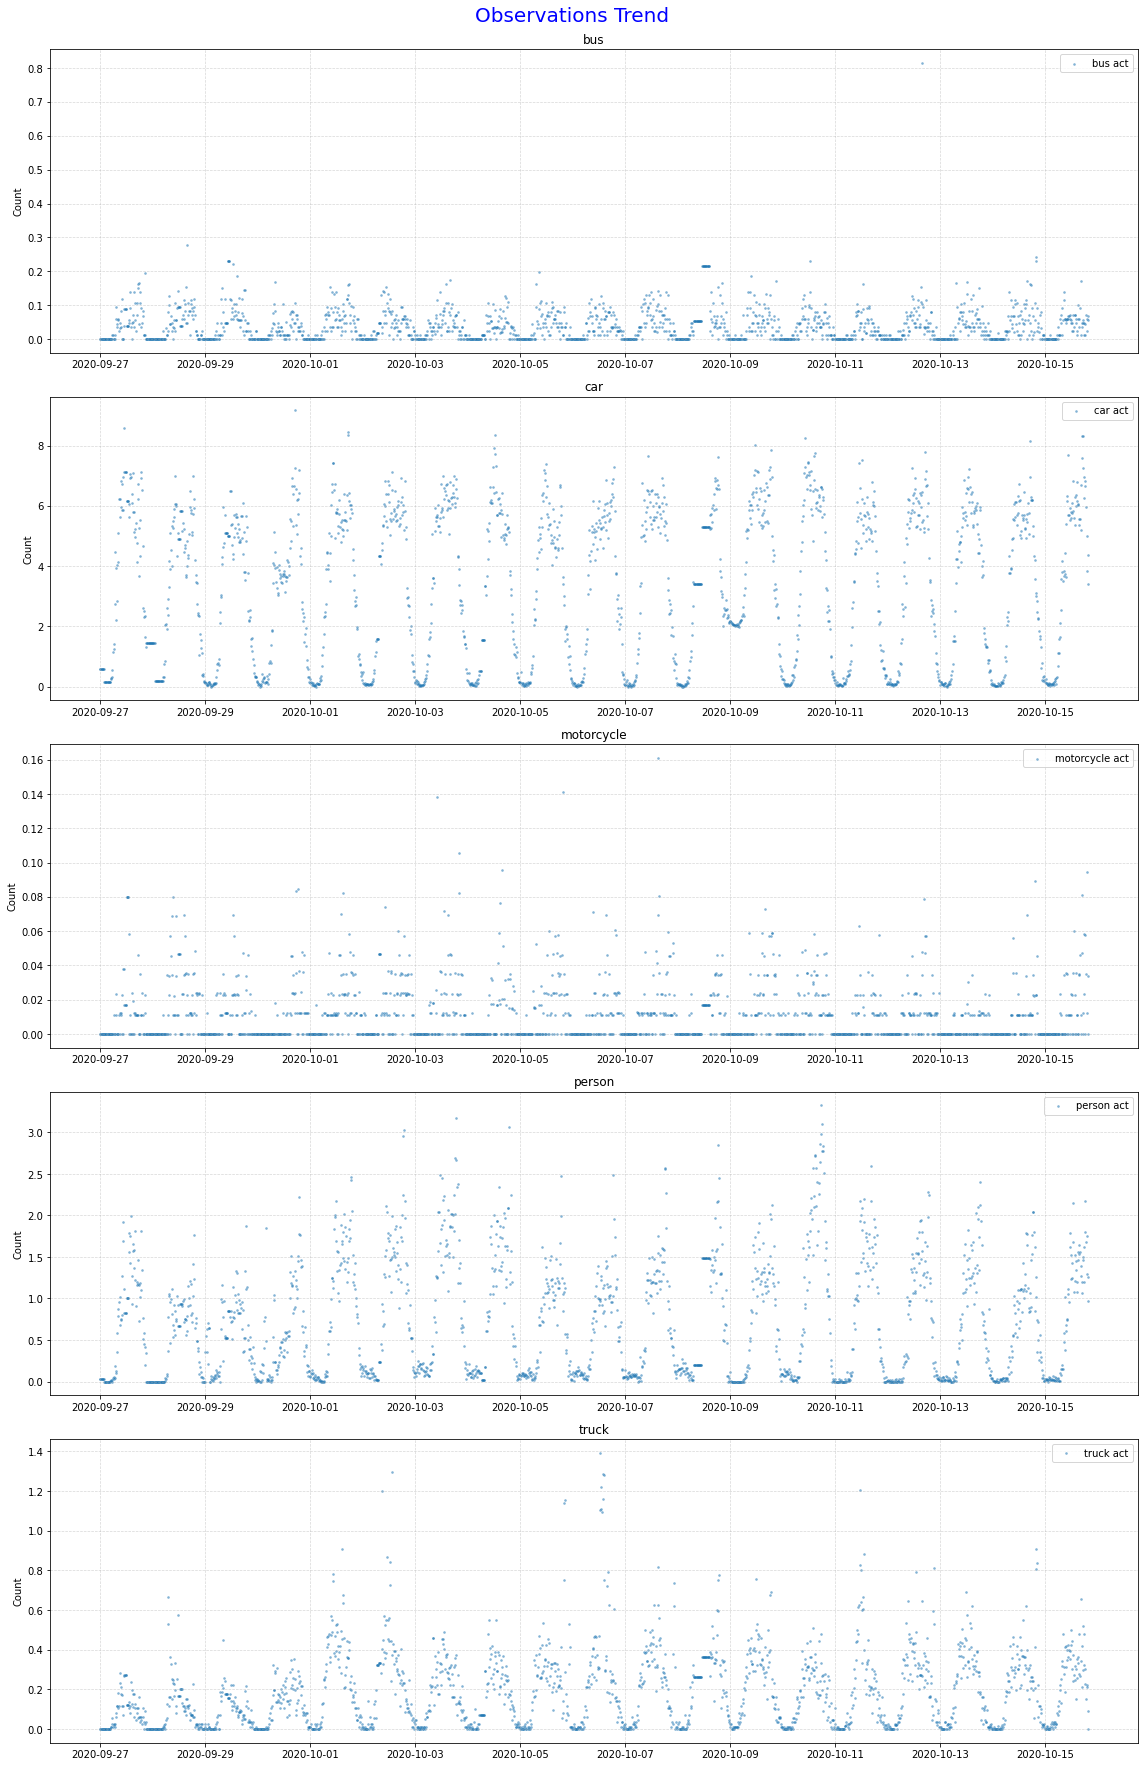

In [14]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,25))
fig.suptitle("Observations Trend\n", fontsize=20, c='b')

plot_df = raw_df[raw_df.time_stamp >= datetime.datetime(2020,9,27)]

for i, c in enumerate(plot_df.class_name.unique()):
    _p = plot_df[plot_df.class_name == c]
    subplot[i].scatter(_p.time_stamp, _p.rate, alpha=.4, label=f"{c} act", s=3)

    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [15]:
raw_df = raw_df[raw_df.time_stamp >= datetime.datetime(2020,9,27)]

In [16]:
print(f"{'Object':15}  {'Count':>10}")
for c in raw_df.class_name.unique():
    print(f"{c:15}  {(raw_df[raw_df.class_name == c]['rate'] != 0).sum():>10}")

Object                Count
bus                    1186
car                    1799
motorcycle              796
person                 1671
truck                  1532


In [17]:
X_train, X_test, y_train, y_test, train_df, test_df = get_train_test_split(raw_df, hours_in_test=7*24, y_intervals=1)


<h1>Predict Based on Weekday Average</h1>
Predict based on each day's average.

In [18]:
train_df.head()

,time_stamp,class_name,class_code,rate,year,month,day,weekday,hour,minute,day_minute,week_minute,midnight
2825,2020-09-27 00:00:00,bus,0,0.0,2020,9,27,6,0,0,0,8640,True
2826,2020-09-27 00:15:00,bus,0,0.0,2020,9,27,6,0,15,15,8655,False
2827,2020-09-27 00:30:00,bus,0,0.0,2020,9,27,6,0,30,30,8670,False
2828,2020-09-27 00:45:00,bus,0,0.0,2020,9,27,6,0,45,45,8685,False
2829,2020-09-27 01:00:00,bus,0,0.0,2020,9,27,6,1,0,60,8700,False


In [19]:
weekdayavg_train_df = train_df[['weekday', 'class_name', 'rate']].groupby(['weekday', 'class_name']).agg([np.mean, np.std])
weekdayavg_test_df = test_df[['weekday', 'class_name', 'rate']].groupby(['weekday', 'class_name']).agg([np.mean, np.std])

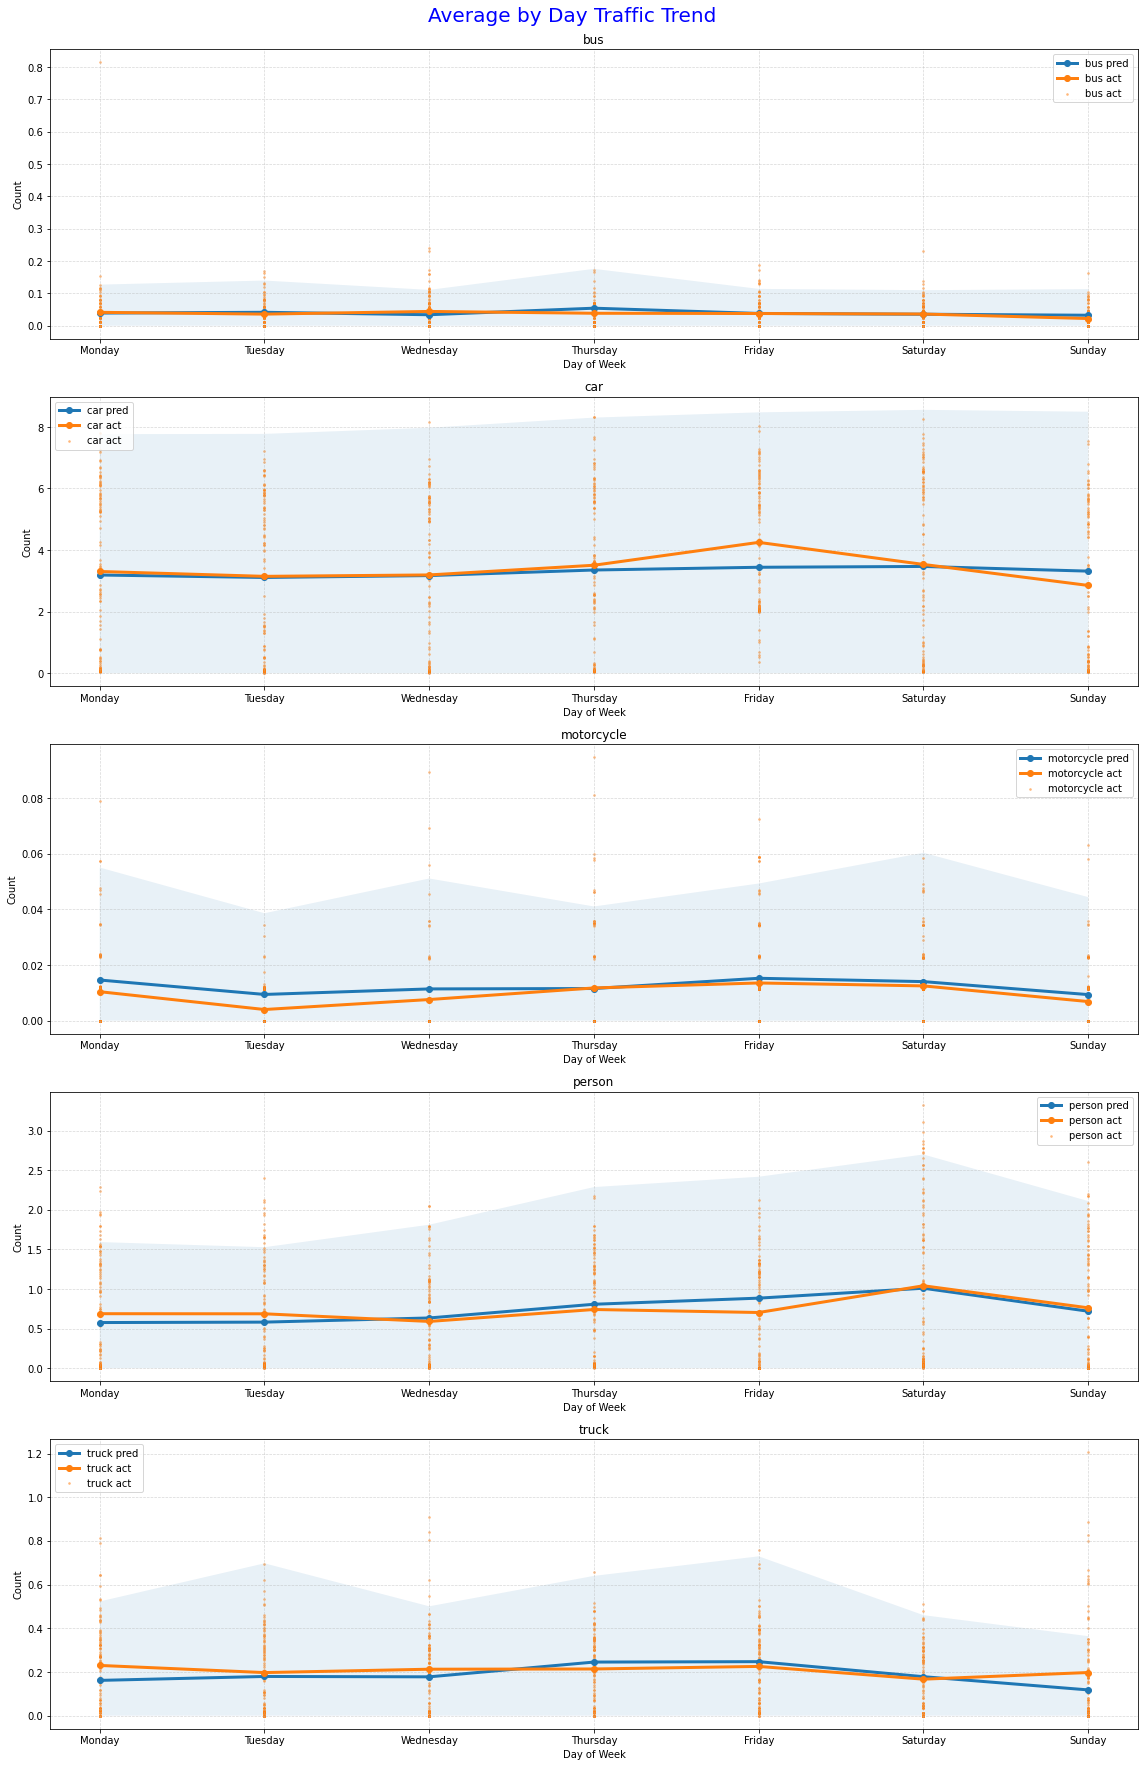

In [20]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Day Traffic Trend\n", fontsize=20, c='b')

_train_df = weekdayavg_train_df
_test_df = weekdayavg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(test_df[test_df.class_name == c].weekday, test_df[test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Day of Week")
    tick_locations = range(0,7)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

Measure accuracy

In [21]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(weekdayavg_test_df.index.get_level_values(1).unique()):
    true = weekdayavg_test_df[weekdayavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = weekdayavg_train_df[weekdayavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus          -0.676
car           0.219
motorcycle   -0.013
person        0.455
truck          -4.2


<h1>Predict by Hour of Day</h1>
Predict based on the time of day.

In [22]:
houravg_train_df = train_df[['hour', 'class_name', 'rate']].groupby(['hour', 'class_name']).agg([np.mean, np.std])
houravg_test_df = test_df[['hour', 'class_name', 'rate']].groupby(['hour', 'class_name']).agg([np.mean, np.std])

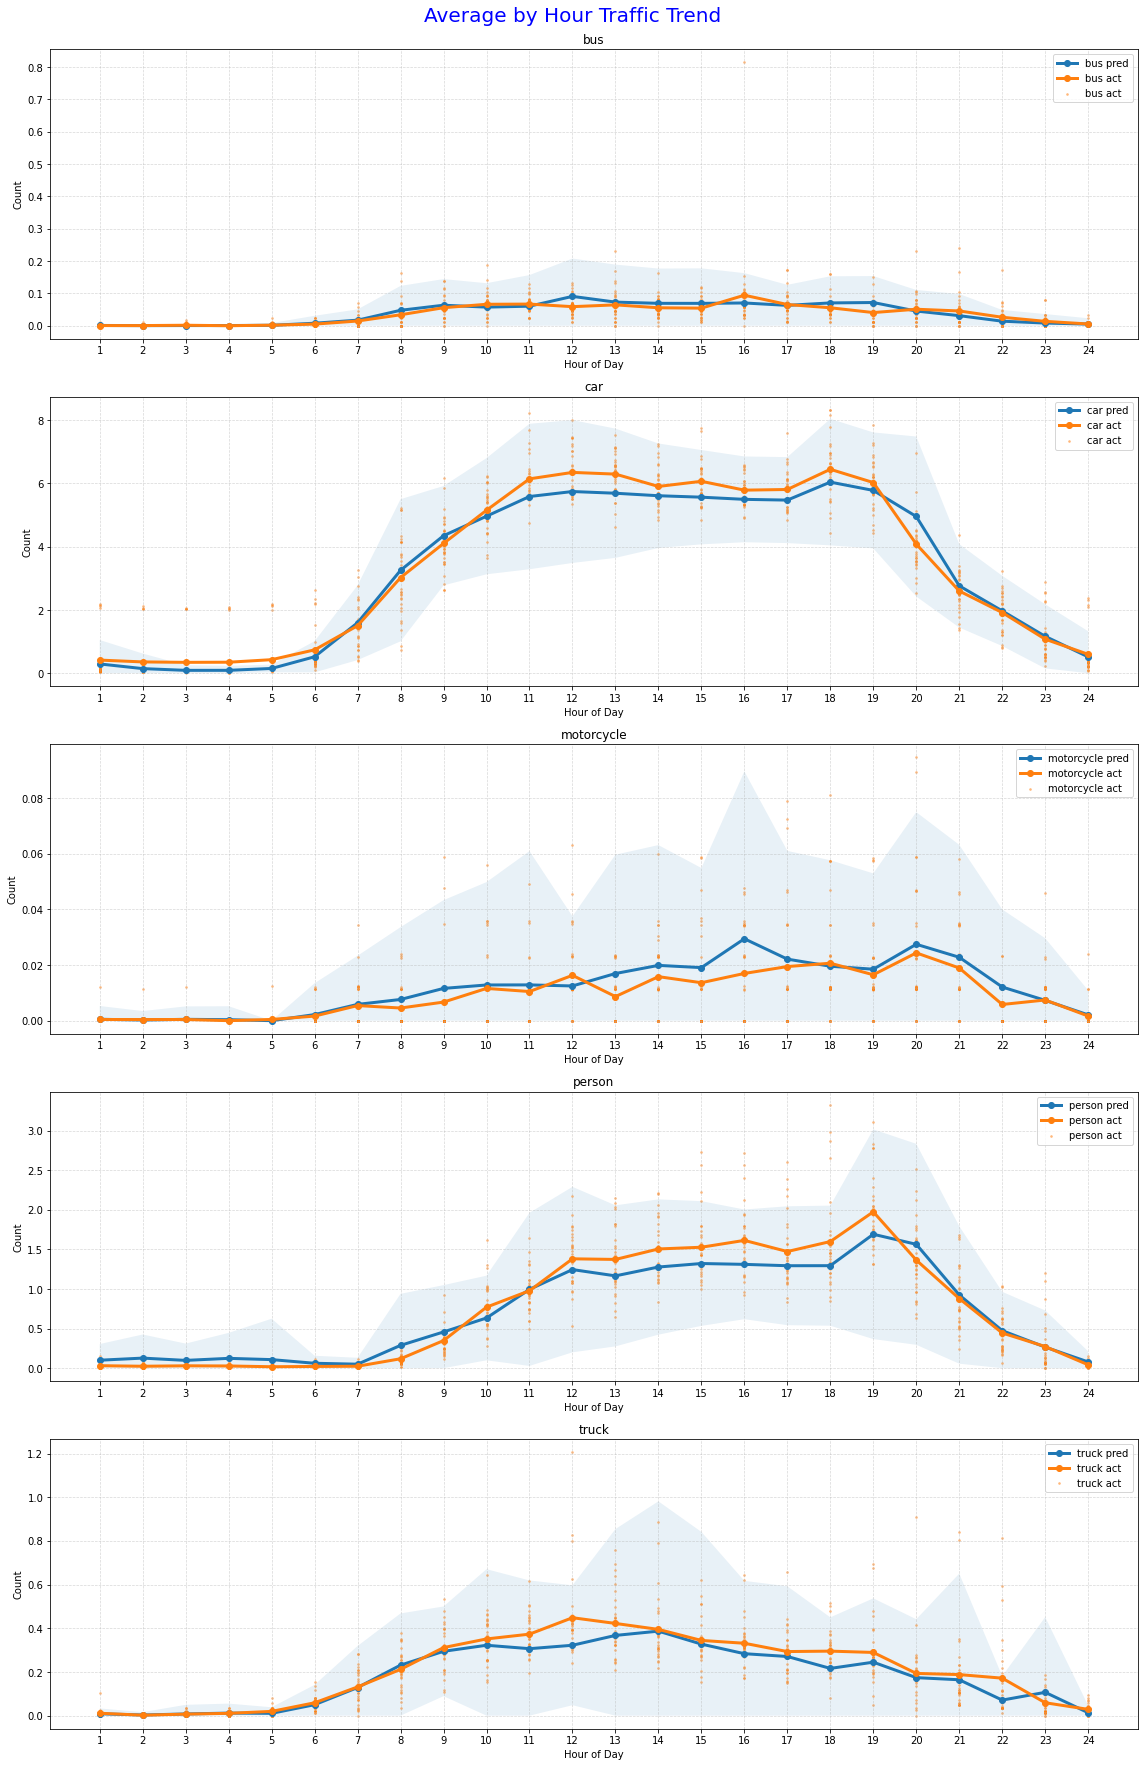

In [23]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Hour Traffic Trend\n", fontsize=20, c='b')

_train_df = houravg_train_df
_test_df = houravg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(test_df[test_df.class_name == c].hour, test_df[test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Hour of Day")
    tick_locations = range(0,24)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(range(1,25))
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [24]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(houravg_test_df.index.get_level_values(1).unique()):
    true = houravg_test_df[houravg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = houravg_train_df[houravg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus            0.78
car           0.978
motorcycle    0.703
person        0.946
truck         0.906


<h1>Predict by X minute Interval of Day</h1>
Predict based on the time of day.

In [25]:
train_df.head()

,time_stamp,class_name,class_code,rate,year,month,day,weekday,hour,minute,day_minute,week_minute,midnight
2825,2020-09-27 00:00:00,bus,0,0.0,2020,9,27,6,0,0,0,8640,True
2826,2020-09-27 00:15:00,bus,0,0.0,2020,9,27,6,0,15,15,8655,False
2827,2020-09-27 00:30:00,bus,0,0.0,2020,9,27,6,0,30,30,8670,False
2828,2020-09-27 00:45:00,bus,0,0.0,2020,9,27,6,0,45,45,8685,False
2829,2020-09-27 01:00:00,bus,0,0.0,2020,9,27,6,1,0,60,8700,False


In [26]:
intavg_train_df = train_df[['day_minute', 'class_name', 'rate']].groupby(['day_minute', 'class_name']).agg([np.mean, np.std])
intavg_test_df = test_df[['day_minute', 'class_name', 'rate']].groupby(['day_minute', 'class_name']).agg([np.mean, np.std])

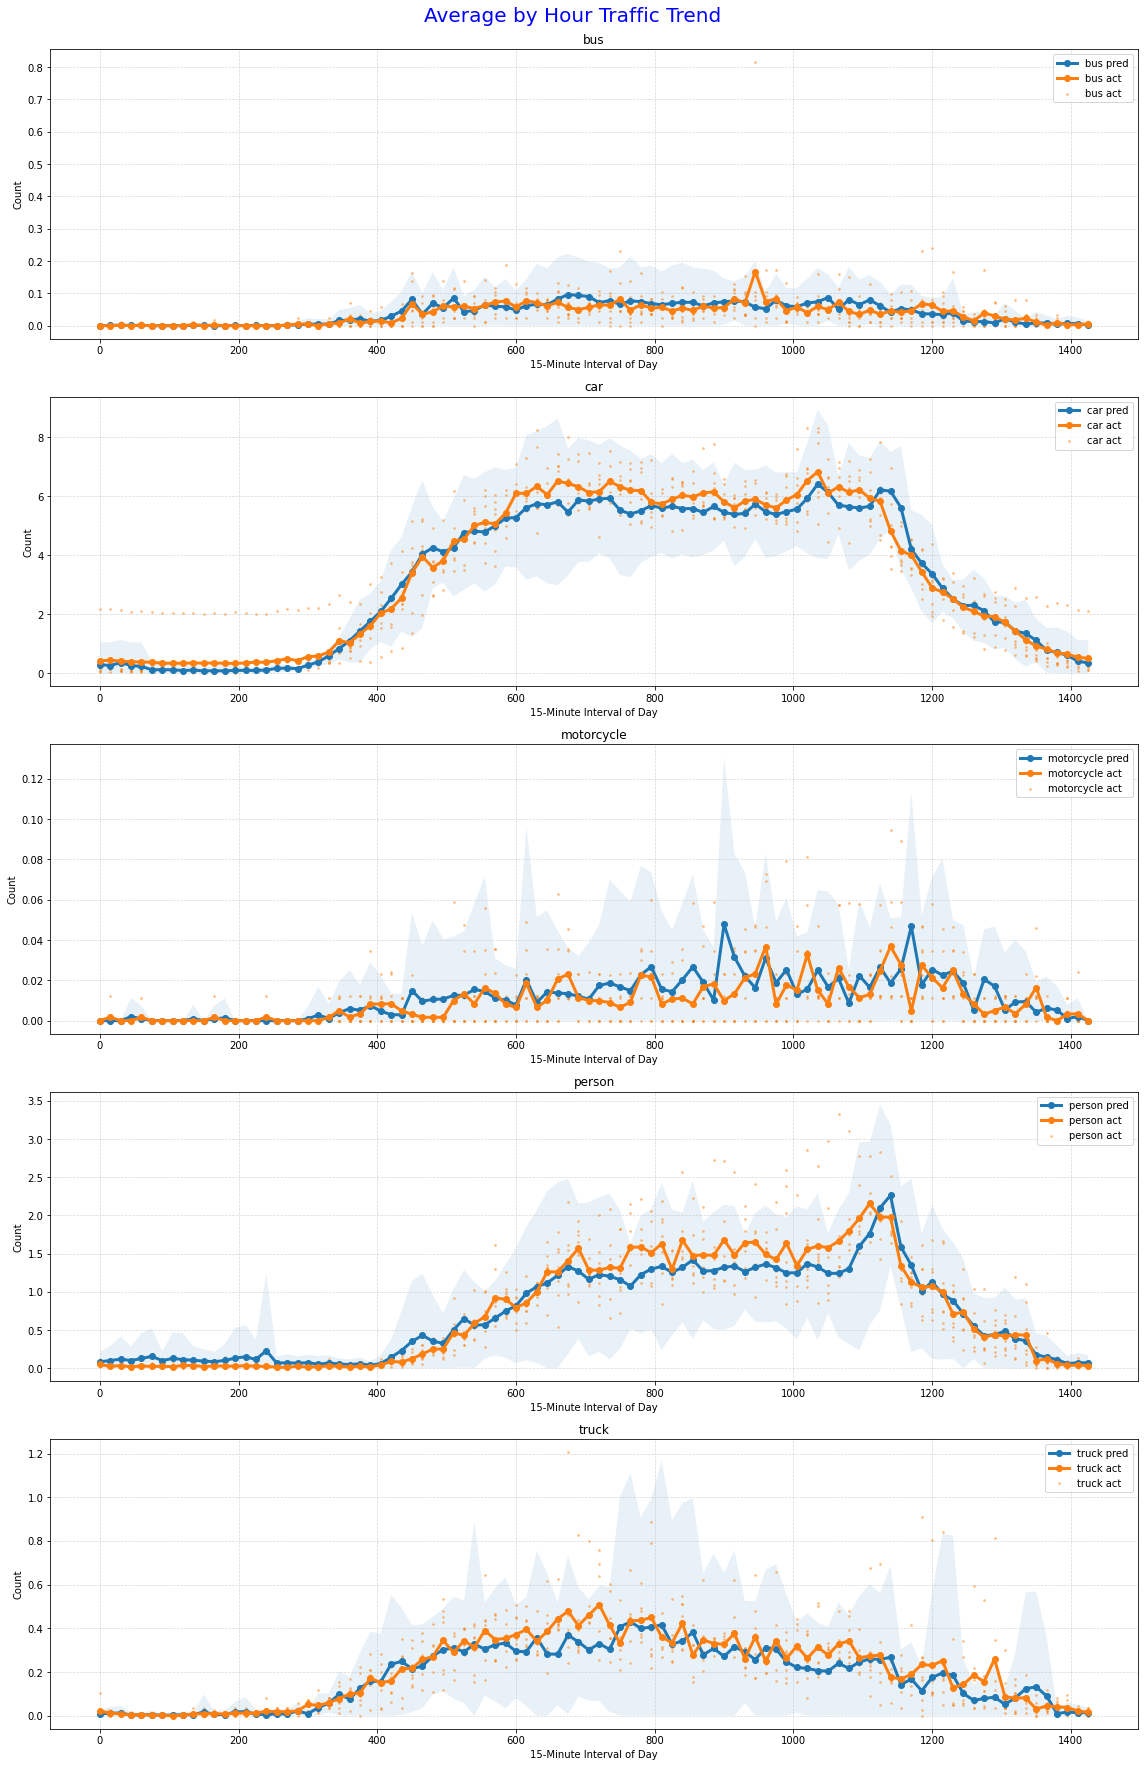

In [27]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Hour Traffic Trend\n", fontsize=20, c='b')

_train_df = intavg_train_df
_test_df = intavg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(test_df[test_df.class_name == c].day_minute, test_df[test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("15-Minute Interval of Day")
#     tick_locations = range(0,24*4)
#     subplot[i].set_xticks(tick_locations)
#     subplot[i].set_xticklabels(range(0,24*4))
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [28]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(intavg_test_df.index.get_level_values(1).unique()):
    true = intavg_test_df[intavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = intavg_train_df[intavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus            0.59
car           0.972
motorcycle    0.087
person        0.929
truck          0.83


<h1>Predict by Time of Day and Day of Week</h1>
Use the time of the day and the day of the week.

In [29]:
weekminavg_train_df = train_df[['week_minute', 'class_name', 'rate']].groupby(['week_minute', 'class_name']).agg([np.mean, np.std])
weekminavg_test_df = test_df[['week_minute', 'class_name', 'rate']].groupby(['week_minute', 'class_name']).agg([np.mean, np.std])

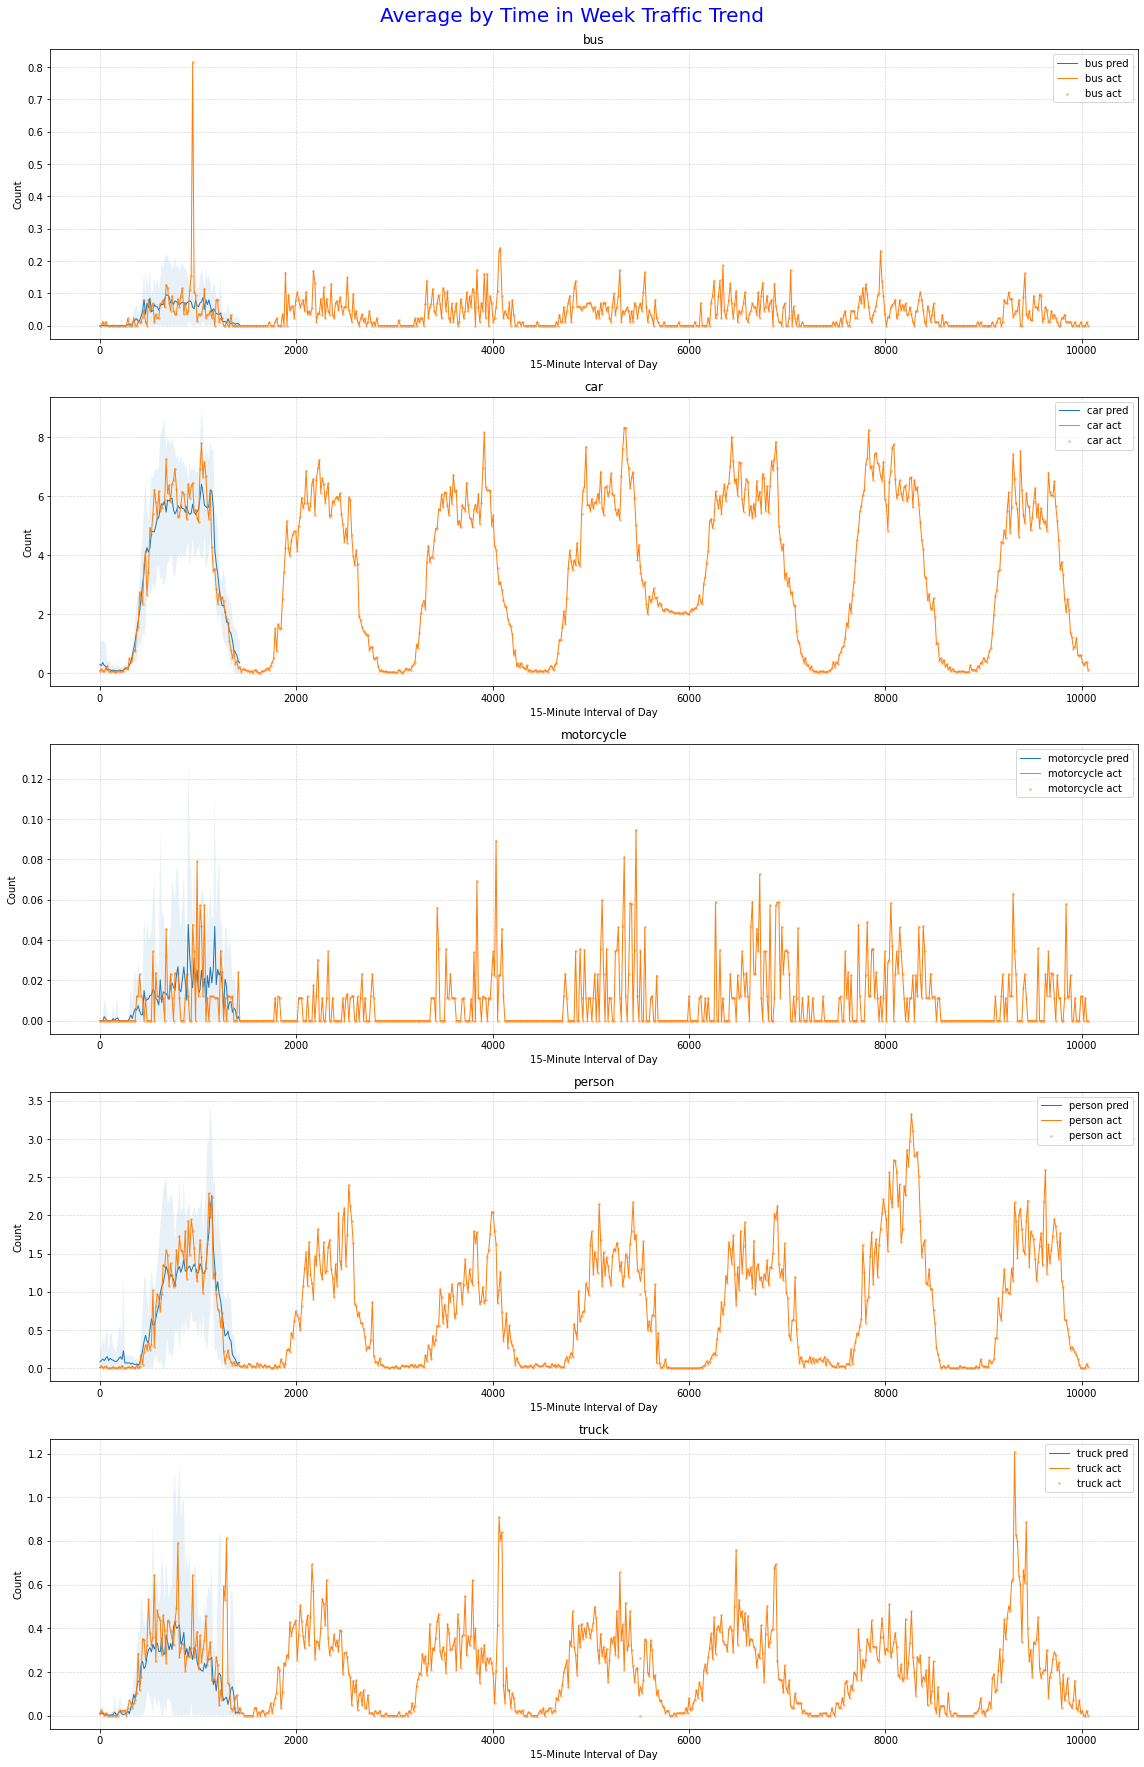

In [30]:
fig, subplot = plt.subplots(nrows=len(categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Time in Week Traffic Trend\n", fontsize=20, c='b')

_pred_df = weekminavg_train_df
_test_df = weekminavg_test_df

for i, c in enumerate(_pred_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", lw=1)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(test_df[test_df.class_name == c].week_minute, test_df[test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", lw=1)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("15-Minute Interval of Day")
#     tick_locations = range(0,24*4)
#     subplot[i].set_xticks(tick_locations)
#     subplot[i].set_xticklabels(range(0,24*4))
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [31]:
# print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(weekminavg_test_df.index.get_level_values(1).unique()):
    true = weekminavg_test_df[weekminavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = weekminavg_train_df[weekminavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

bus           0.095
car            0.88
motorcycle   -0.516
person         0.76
truck         0.319


<h1>Baseline Model Results</h1>

<b>Weekday Average</b> <br>
This is the worst performing model and is no surprise.  Here, we predict the observation rate based on the overall average of each day of the week.  This will take into account that some days are busier than others, but does not consider the time of day when making prdictions.

<b>Time of Day</b> <br>
Making predictions based on the time of the day yields better results.  Here, we consider the time of the day, but not the day of the week.

<b>Day and Time</b> <br>
Lastly, we use both the day of the week and the time of the day to make prdictions.  Both the R2 and MSE scores improve which makes sense and is expected.  We will consider this our baseline model.

<h1>Model Design</h1> <br>
To improve on the baseline, we need to consider the previous trend.  Doing so would reflect things like seasonality, weather or special events.  For example, if Monday is slow, we may be able to expect that Tuesday is slow or if things are slow at 9am, they may also be slow at 3pm.  This will not take holidays into effect, so we may want to add holidays to the source data.

Our final objective is to predict the next day's traffic pattern at the end of each day.

<b>Step 1: Predict the next 15min rate.</b> <br>
- Use previous observations to record the next 15 minute interval as a single point.

<b>Step 2: Predict the next hour in 15min increments</b> <br>
- Predict several points in the future.

<b>Step 3: Explore other models</b> <br>
- Remove the poorest performing models from the mix.  Identify other models that may make up for shortcomings of selected models.

<b>Step 4: Finalize Models</b> <br>
- Determine best final model or combination of models to use as the final design.


<b>Step 5: Build prediction programs and incorporate into final product</b> <br>
- Revise the charting service in the monitor application to reflect preductions.
- Include the current accuracy of the model and update it dynamically.
- Build aplication so that at the end of each day, the models are refit with the new model data and predictions for the next day are built and charted.


<h2>Feature Engineering</h2> <br>

- Each 15minute increment will be predicted based on the previous 24hrs of 15min increments.
- For each observation, we will create a column for each 15min observation of the previous 24 hours

In [32]:
_df = set_interval(pd.DataFrame(get_rs()), interval=15)
_df = _df[_df.time_stamp >= datetime.datetime(2020,9,27)]
_df = add_category_codes(_df, 'class_name', 'class_code')
_df = extend(_df)
_df = add_history_columns(_df, value_column='rate', category_column='class_name', n_intervals=24*4)
# _df = add_future_columns(_df, value_column='rate', category_column='class_name', n_intervals=24*4)

cat_map_name_to_code = _df[['class_name', 'class_code']].set_index('class_name').drop_duplicates().to_dict()['class_code']
cat_map_code_to_name = _df[['class_name', 'class_code']].set_index('class_code').drop_duplicates().to_dict()['class_name']

_df.head()

,time_stamp,class_name,class_code,rate,year,month,day,weekday,hour,minute,...,-87,-88,-89,-90,-91,-92,-93,-94,-95,-96
0,2020-09-28 00:00:00,bus,0,0.0,2020,9,28,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-09-28 00:15:00,bus,0,0.0,2020,9,28,0,0,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-09-28 00:30:00,bus,0,0.0,2020,9,28,0,0,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-09-28 00:45:00,bus,0,0.0,2020,9,28,0,0,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-09-28 01:00:00,bus,0,0.0,2020,9,28,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
X_train, X_test, y_train, y_test, train_df, test_df = get_train_test_split(_df, hours_in_test=24, y_intervals=1)

<h2>Model Evaluation</h2>
First, we evaluate models trained with each individual classs name, one at a time.
These models will not take into account any correlation between rates from different objects that are detected.

In [34]:
_models = []
_models.append(('LinReg', LinearRegression()))
# _models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
# _models.append(('KNN', KNeighborsRegressor(n_neighbors=shifts))) 
_models.append(('DecTree', DecisionTreeRegressor(max_depth= 10, random_state=0)))
_models.append(('RF', RandomForestRegressor(n_jobs=-1, n_estimators = 150, random_state=0))) 
_models.append(('GradientBoost', GradientBoostingRegressor(n_estimators = 150, random_state=0))) 
# _models.append(('AdaBoost', AdaBoostRegressor(n_estimators = 150, random_state=0))) 
# _models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
_models.append(('LinearGAM', LinearGAM()))


In [35]:
def evaluate(_tr_df, _te_df, train_x_cols, train_y_cols):
    
    _tr_x = _tr_df[train_x_cols].reset_index(drop=True)
    _te_x = _te_df[train_x_cols].reset_index(drop=True)
    
    _tr_y = _tr_df[train_y_cols].reset_index(drop=True)
    _te_y = _te_df[train_y_cols].reset_index(drop=True)
       
    print(f"Train Cols: {[c for c in train_x_cols if not c.startswith('-')]}")
    
    for name, model in _models:
        if name == 'LinearGAM':
            terms = None
            for i, c in enumerate(_tr_x.columns):
                if c.startswith('-'):
                    if terms == None:
                        terms = s(i)
                    else:
                        terms += s(i)
                else:
                    if terms == None:
                        terms = f(i)
                    else:
                        terms += f(i)
            m = LinearGAM(terms=terms).fit(_tr_x, _tr_y)
            y_pred = np.clip(m.predict(_te_x), a_min=0, a_max=None)
            r2 = r2_score(y_true=_te_y,y_pred=y_pred)
            print(f"{name:15}: r2 mean-> {round(r2, 3):>6}")
        else:
            tscv = TimeSeriesSplit(n_splits=8)  
            cv_results = cross_val_score(model, _tr_x, _tr_y, cv=tscv, scoring='r2', n_jobs=-1)
            print(f"{name:15}: r2 mean-> {round(cv_results.mean(), 3):>6} std-> {round(cv_results.std(), 3):>6}")

In [36]:
train_x_cols = ['class_code'] + [c for c in train_df.columns[::-1] if c.startswith('-')]
train_y_cols = 'rate'
evaluate(train_df, test_df, train_x_cols, train_y_cols)

Train Cols: ['class_code']
LinReg         : r2 mean-> -1.9330251051213699e+18 std-> 5.114303706195632e+18
DecTree        : r2 mean->    0.3 std->  0.535
RF             : r2 mean->  0.588 std->  0.365
GradientBoost  : r2 mean->  0.593 std->  0.469
LinearGAM      : r2 mean->   0.97


In [37]:
train_x_cols = ['class_code', 'weekday'] + [c for c in train_df.columns[::-1] if c.startswith('-')]
train_y_cols = 'rate'
evaluate(train_df, test_df, train_x_cols, train_y_cols)

Train Cols: ['class_code', 'weekday']
LinReg         : r2 mean-> -7.51550823824034e+17 std-> 1.9884165774641114e+18
DecTree        : r2 mean->   0.28 std->  0.566
RF             : r2 mean->  0.591 std->  0.363
GradientBoost  : r2 mean->  0.594 std->  0.467
LinearGAM      : r2 mean->   0.97


In [38]:
train_x_cols = ['class_code', 'weekday', 'hour', 'minute'] + [c for c in train_df.columns[::-1] if c.startswith('-')]
train_y_cols = 'rate'
evaluate(train_df, test_df, train_x_cols, train_y_cols)

Train Cols: ['class_code', 'weekday', 'hour', 'minute']
LinReg         : r2 mean-> -1734697586079757.0 std-> 4589578412671099.0
DecTree        : r2 mean->   0.37 std->  0.482
RF             : r2 mean->  0.586 std->  0.366
GradientBoost  : r2 mean->  0.592 std->  0.467
LinearGAM      : r2 mean->   0.97


<h3>Quick Evaluation Results</h3>
Our best performers are the RandomForest, Gradient Descent and Linear GAM models.  The RandomForest and Gradient Descent scores are notably low as a result of how scikit scores models evaluated using cross validation and the fact that we are using a TimeSeries split of folds for the cross validation.  When weook closer at these models, we can expect to see higher   For now, we just want to do a quick validation to see models may perform best afater we do some model prapmeter fine-tuning.

<h3>Fine-Tuning</h3>
Let's fine-tune the best performers: RandomForest, GadientBoost, LinearGAM

In [39]:
def execute_grid_search(_tr_df, _te_df, model, param_search, train_x_cols, train_y_cols) -> dict:
    results = {}
    
    _tr_y = _tr_df[train_y_cols].reset_index(drop=True)
    _te_y = _te_df[train_y_cols].reset_index(drop=True)
    _tr_x = _tr_df[train_x_cols].reset_index(drop=True)
    _te_x = _te_df[train_x_cols].reset_index(drop=True)
    
    # LinerGAM is not a ascikit model and will be handled separately.
    # The only pramter we use here is the lam (aka - smoother)
    if model.__class__.__name__ == "LinearGAM":
        best_score = 0
        for lam in param_search.get('lam'):
            terms = None
            for i, c in enumerate(_tr_x.columns):
                if c.startswith('-') or c.startswith('+'):
                    if terms == None:
                        terms = s(i, lam=lam)
                    else:
                        terms += s(i, lam=lam)
                else:
                    if terms == None:
                        terms = f(i)
                    else:
                        terms += f(i)
            _m = LinearGAM(terms=terms)
            y_pred = np.clip(_m.fit(_tr_x, _tr_y).predict(_te_x), a_min=0, a_max=None)
            _score = r2_score(y_true=_te_y,y_pred=y_pred)
            if _score > best_score:
                best_score = _score
                best_lam = lam
                best_model = _m
            print(f"lam: {lam:5}  r2: {_score}")
        
        best_params = f"\tlam: {best_lam}"
        
    else:
        tscv = TimeSeriesSplit(n_splits=8)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2', verbose=0, n_jobs=-1)
        gsearch.fit(_tr_x, _tr_y)
        best_model = gsearch.best_estimator_
        y_pred = np.clip(best_model.predict(_te_x), a_min=0, a_max=None)
        best_score = r2_score(y_true=_te_y, y_pred=y_pred)
        best_params = f"\t{' | '.join([f'{p}: {str(getattr(best_model, p))}' for p in param_search])}"

    print(model.__class__.__name__)
    print(f"Train Cols: {[c for c in _tr_x.columns if not (c.startswith('-'))]}")
    print(f"\tBest Model's R2 Score: {round(best_score, 4)}")
    print(f"\tBest Parameters: {best_params}")
    print(f"\tScore By Class:")
    for class_name in _te_df.class_name.unique():
        idxs = _te_x[_te_x.class_code == cat_map_name_to_code.get(class_name)].index
        r2 = r2_score(y_true=_te_y[idxs], y_pred=y_pred[idxs])
        print(f"\t\t{class_name:10}: {round(r2, 4):>6}")
        results.update({class_name: r2})
        
    results.update({'best_model': best_model})
    results.update({'best_overall_score': best_score})
    
    return {model.__class__.__name__: results}

In [40]:
onesize_results = {}
train_x_cols = ['class_code'] + [c for c in train_df.columns[::-1] if c.startswith('-')]
train_y_cols = 'rate'

In [41]:
model = LinearGAM()
param_search = { 
    'lam': [725, 750, 775, 800, 825, 850, 8758],
}

onesize_results = {**onesize_results, **execute_grid_search(train_df, test_df, model, param_search, train_x_cols, train_y_cols)}

lam:   750  r2: 0.9806418652845759
lam:   775  r2: 0.9806534925764284
lam:   800  r2: 0.9806644028411952
lam:   825  r2: 0.9806746497930682
lam:   850  r2: 0.9806842820187436
LinearGAM
Train Cols: ['class_code']
	Best Model's R2 Score: 0.9807
	Best Parameters: 	lam: 850
	Score By Class:
		bus       : 0.3253
		car       : 0.9666
		motorcycle: 0.0396
		person    : 0.8972
		truck     : 0.6044


In [42]:
model = RandomForestRegressor(n_jobs=-1, random_state=0)
param_search = { 
    'n_estimators': [10, 20, 50, 100],
    'max_features': ['auto'], #, 'sqrt', 'log2'], -> the best scores are always auto
    'max_depth' : [i for i in range(5,15)]
}

onesize_results = {**onesize_results, **execute_grid_search(train_df, test_df, model, param_search, train_x_cols, train_y_cols)}

RandomForestRegressor
Train Cols: ['class_code']
	Best Model's R2 Score: 0.9772
	Best Parameters: 	n_estimators: 20 | max_features: auto | max_depth: 14
	Score By Class:
		bus       : 0.2307
		car       : 0.9593
		motorcycle: 0.2677
		person    : 0.8931
		truck     : 0.6107


In [43]:
# model = GradientBoostingRegressor(random_state=0)
# param_search = { 
#     'n_estimators': [20, 50, 100],
#     'learning_rate' : [.05, .1, .5, 1],
#     'loss' : ['ls', 'lad', 'huber', 'quantile']
# }

# onesize_results = {**onesize_results, **execute_grid_search(train_df, test_df, model, param_search, train_x_cols, train_y_cols)}

GradientBoostingRegressor
Train Cols: ['class_code']
	Best Model's R2 Score: 0.9736
	Best Parameters: 	n_estimators: 100 | learning_rate: 0.05 | loss: lad
	Score By Class:
		bus       : 0.3789
		car       : 0.9521
		motorcycle: 0.1307
		person    : 0.8842
		truck     : 0.5695


In [44]:
pd.DataFrame(onesize_results)

,LinearGAM,RandomForestRegressor,GradientBoostingRegressor
bus,0.325305,0.230712,0.378947
car,0.966625,0.959263,0.95207
motorcycle,0.0396219,0.267699,0.130652
person,0.897163,0.893091,0.884195
truck,0.604406,0.610655,0.569459
best_model,"LinearGAM(callbacks=[Deviance(), Diffs()], fit...","(DecisionTreeRegressor(max_depth=14, max_featu...",([DecisionTreeRegressor(criterion='friedman_ms...
best_overall_score,0.980684,0.9772,0.97356


<h3>Conclusion</h3>
After picking our best 3 overall performers and evaluating them for predicting each class, we observe that the parametrice models perform better despit an overall lower score than the LinearGAM.  Of the non-parametric models, the GradientBooster has a slight advantage over the RandomForestRegressor.

Based on pure numerical results, the GradientBooster is the best, but since we see varying results, I consider the comparisons inconclusice and will choose to visualize all models before drawing a final conclusion.

<h3>Visualize Model Predictions</h3>
These models only predict the next minute interval values. This is not very useful.  We will string predictions together to create the prediction for an entire day.

In [45]:
def string_predictions(trained_model, _test_df, train_x_cols, train_y_cols):
    
    n_intervals = len([c for c in train_x_cols if c.startswith('-')]) # add 1 for the rate column
    n_predictors = 1 if type(train_y_cols) == str else len([c for c in train_y_cols])
    _test_df = _test_df.reset_index(drop=True)
    
    
    # get the first test observation that includes all cateogries
    found = False
    i = 0
    while not found:
        t = _test_df.iloc[i].time_stamp
        if set(test_df[test_df.time_stamp == t].class_name.values) == set(_test_df.class_name.unique()):
            found = True
        
    # create the starting point from which to string future predictions
    X = _test_df[_test_df.time_stamp == t][train_x_cols].copy().reset_index(drop=True)
    
    # String predictions
    for i in range(n_intervals+1):
        r = list(range(n_predictors)) + list(range(len(X.columns)-n_intervals, len(X.columns)))
        X[f"+{i}"] = np.clip(trained_model.predict(X.iloc[:,r]), a_min=0, a_max=None)
        
    # Reformat results into dataframe of similar stucture to the original train and test dataframes
    pred_df = X.iloc[:,r].T.iloc[1:,:]
    time_stamps = [t + pd.Timedelta(f'{15*(i+1)} minutes') for i,_ in enumerate(pred_df.index)]
    pred_df.index = time_stamps

    # rename the columns
    pred_df.columns = [cat_map_code_to_name.get(c) for c in pred_df.columns]

    # melt the columns
    pred_df = pred_df.melt(ignore_index=False, var_name='class_name', value_name='rate').reset_index().rename(columns={'index':'time_stamp'})

    # extend a colum for the codes the codes
    pred_df = add_category_codes(pred_df, 'class_name', 'class_code')

    # extend columns for time characteristics
    pred_df = extend(pred_df)

    return pred_df
    

In [46]:
def plot_preds(model_name, _train_df, _test_df, _x_cols, _y_cols):
    trained_model = onesize_results.get(model_name)['best_model'].fit(_train_df[_x_cols].copy().reset_index(drop=True), _train_df[_y_cols])
    pred_df = string_predictions(trained_model, _test_df, _x_cols, _y_cols)
    
    fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
    fig.suptitle(f"Best Model Actual vs. Prediction \n {model_name}", fontsize=20, c='b')

    cmap = plt.get_cmap('Dark2')
    N = len(_test_df.class_name.unique())
    for i, c in enumerate(_test_df.class_name.unique()):
        _act_df = _test_df[_test_df.class_name == c]
        _pred_df = pred_df[pred_df.class_name == c]
        color = cmap(float(i)/N)
        subplot.scatter(_act_df.time_stamp, _act_df.rate, alpha=.5, color=color)
        subplot.plot(_act_df.time_stamp, _act_df.rate, label=f"{c} actual", lw=1, ls='--', alpha=.5, c=color)
        subplot.plot(_pred_df.time_stamp, _pred_df.rate, label=f"{c} pred", lw=2, c=color)
        subplot.grid(linestyle='--', alpha=.5, linewidth=.7)
        subplot.legend()

    plt.show()


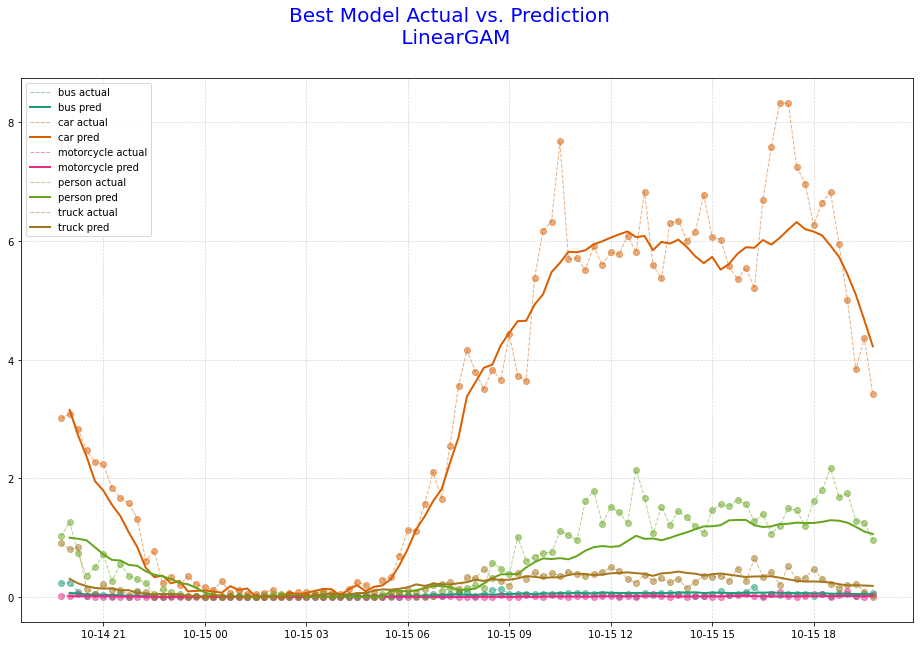

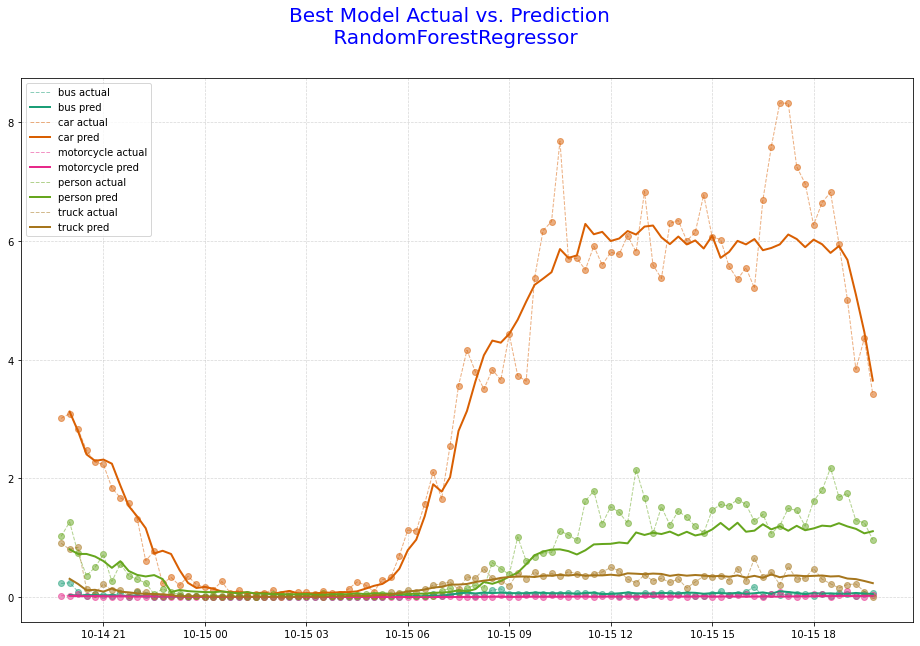

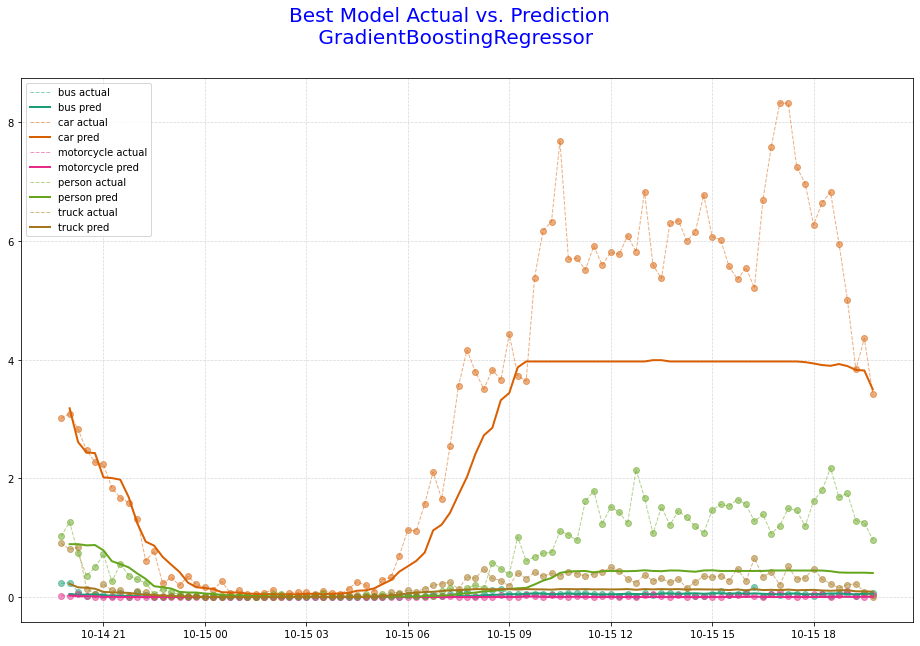

In [47]:
for m in onesize_results.keys():
    plot_preds(m, train_df, test_df, train_x_cols, train_y_cols)

<h3>Result</h3>
Since the models only predict the next 15 minute increment, we use a stringing process to build a day's predictions by creating successive predictions.  After reviewing several different time periods, the LinearGAM performed the most consistely well.  Although, the RandomForest and GradientDescent models also did well, they can yield unreasonable results during periods of low(RF) or high(GD) activity.

We will choose the LinearGAM as the preferred model for this data set.